# Data extraction from trace
This notebook aims to take the `.pcap` files generated from the trace and use those to create a csv file that contains the features and labels to input to our classifier.

In [1]:
import ipaddress
import os
import sys
import time
from functools import reduce
from multiprocessing import Pool
from typing import Any, List, Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.core.frame import DataFrame
from scapy.all import *
from scipy import stats


## Client-Server interaction - which data should be kept
We first recall the implementation of client server interaction. Indeed, this one is described in `handout_project_secretstroll.pdf`. Taking a look at implementation of `server.py` and `client.py`, we must make key observations:
### PoI answers - size and shuffling
* When querying the server, the client will sequentially:
  * retrieve the list of PoI (**which can pretty much vary in size between grids**)
  * the client then iterates through each PoI -> **no shuffling** is performed at any step, this lets us suppose that 2 queries for the same grid will produce a **same sequence of queries for the PoI infos** to the server.
  * they make a query to retrieve the PoI infos for each. We must note that the **number of PoI ratings may vary a lot from a PoI to another**, making a PoI info response trace pretty unique.
* When receiving client's queries, the server will:
  * return the list of around PoI (as explained with a probably preserved order between queries). Here comes a pretty nasty trick: the **implementation given seems to not take into account the variety of possible queries**. Indeed, independently of the queries `types` of PoI (the user subscription), the server will in any case answer by **giving the full list of PoI in the grid** (`records = PoI.query.filter_by(grid_id=grid_id).all()`). This should not happen under the functionnalities described in the handout, but we'll make an adapted training set that will not need to test different types of queries, only the grid ID will vary. If we were to make the attack under fully functionnal system, we'd make a way bigger training set considering the different subscription traces and their combinations.
  * when queried on the info for the point of interest, makes an answer that contains all its information. Note that the **number of ratings associated to a PoI has the most significant impact on the trace**.

### Interaction through tor network
Finally, a last point that should be mentionned is the **usage of tor**:
* [tor does repacketisation](https://gitlab.torproject.org/tpo/core/torspec/-/blob/main/tor-spec.txt#L488) to obtain a fixed size payload. Therefore we probably **won't find any interesting feature in the payload size**
* the queries and answers goes through real tor (we can observe the destination ip addresses that are those of real nodes). This yields excessively longer times for getting answers. We have the intuition that the network randomness will prevent an attacker to have meaningful information from the timings of the observed trace. We make a few extra capture and record times to confirm or not our intuition.

The script `tor_time.sh` can be run assuming a runing server and the installation of `bc` (`apt-get install bc`) utility.

It basically records the time took to make the query with and without tor for a few grids. We ran it 3 times for the 30 first grids and it shows the following results:

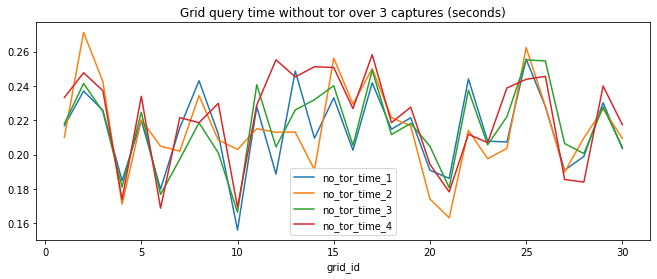

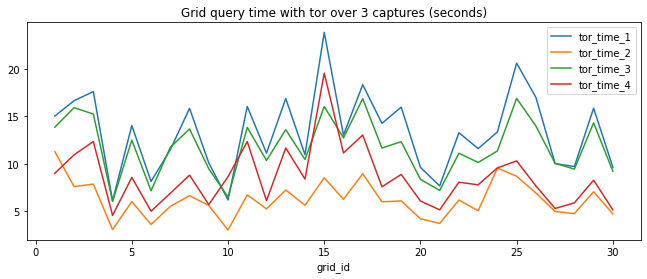

In [2]:
def line_to_tuple(line: str) -> Tuple[int, float]:
    cleaned_line = line.strip().split(":")
    return (int(cleaned_line[0]), float(cleaned_line[1]))


def from_file_to_data(is_with_tor: bool) -> List[Tuple[int, float]]:
    times = []
    for index in range(1, 5):
        with_tor = "tor_" if is_with_tor else "no_tor_"
        filename = "timings_measures/times_" + with_tor + str(index) + ".txt"
        times_i = []
        with open(filename, "r") as file:
            times_i = list(map(line_to_tuple, file.readlines()[1:]))
        times.append(times_i)
    return times


no_tor_times = from_file_to_data(False)
tor_times = from_file_to_data(True)
assert all(len(times) == 30 for times in no_tor_times) and all(
    len(times) == 30 for times in tor_times
)
data = {
    "grid_id": list(map(lambda t: t[0], no_tor_times[0])),
    "no_tor_time_1": list(map(lambda t: t[1], no_tor_times[0])),
    "tor_time_1": list(map(lambda t: t[1], tor_times[0])),
    "no_tor_time_2": list(map(lambda t: t[1], no_tor_times[1])),
    "tor_time_2": list(map(lambda t: t[1], tor_times[1])),
    "no_tor_time_3": list(map(lambda t: t[1], no_tor_times[2])),
    "tor_time_3": list(map(lambda t: t[1], tor_times[2])),
    "no_tor_time_4": list(map(lambda t: t[1], no_tor_times[3])),
    "tor_time_4": list(map(lambda t: t[1], tor_times[3])),
}
times = pd.DataFrame(data)
# Get current axis
times.plot(
    x="grid_id",
    y=["no_tor_time_1", "no_tor_time_2", "no_tor_time_3", "no_tor_time_4"],
    title="Grid query time without tor over 3 captures (seconds)",
    figsize=(11, 4),
    kind="line",
)
plt.show()
times.plot(
    x="grid_id",
    y=["tor_time_1", "tor_time_2", "tor_time_3", "tor_time_4"],
    title="Grid query time with tor over 3 captures (seconds)",
    figsize=(11, 4),
    kind="line",
)
plt.show()


Although we observe that the pikes between the tor and without tor timings are not exactly coherent, we cannot deny that some correlation happens between the tor observed traces for the same grid id queries.

We do not pretend to have reached statistical relevance but the intuition we had about tor killing any pattern of the returned trace does not clearly hold and we'll prefer to continue our study taking it int account.

This takes us to the data-science experience "our theory was wrong" and we'll therefore **keep the timestamps as useful values for the packet representation**.

In [3]:
Packet = Tuple[Literal[-1, 1], float]
"""
represents a packet by its:
- IN/OUT nature (IN == to client == -1) (OUT == to server == 1)
- relative timestamp since the begining of the request for the queried grid
"""

dummy = 1


## Received data
First, the data we receive is in the form of `.pcap` files. Those were filtered to contain only (see `capture.sh`):
* **TCP packets**, other protocols packets are considered not relevant to the application (ARP requests, DNS stuff etc...)
* **packets that have a TCP payload**. Basically all TCP ACKs and other controls packets are filtered and not considered as those depend on the networking related traffic and will noise the core of the application layer generated fingerprint

From those packets, can be retrieved:
* **Ethernet header** (14 bytes, bytes 0 to 13). Those will probably not be relevant for us as depending on the inner Docker networking (or any used LAN environment)
* **IP headers** (20 bytes, bytes 14 to 33). Those bytes mostly contain the routing information (source IP, destination IP, routing flags, etc...). The main information we may want to retrieve from this is the direction of the packets we observe (query or response).
* **TCP headers** (20 bytes, bytes 34 to 53). These bytes contain the stream informations (sequence and ACK indexes, timestamps, payload size, etc...).
* **TLS headers** (10 bytes, bytes 54 to 63). These bytes contains some informations about the version and inner data. the bytes 59 to 63 are the first bytes of the encrypted data which is not recorded as it is not meaningful for us. Indeed the headers already contain the length meta-data and we will not get much more from the correctly encrypted payload (unless we make cryptographic attacks which does not seem reasonnable as the TLS1.2 version is used here).

From this, we are able to define the data we'll want to keep and output to our classifier.

## Desired data model
First, we must decide on the way we'll represent our data as features. As seen before, not all the data will be useful! Our main goal will be to capture in our features the data that contains the most variance between samples of different labels.

The ideal representation would be storing the full trace as our features.
Label (grid_id queried) | Trace (packet list generated)
:---: | :---: 
1 | `[pkt1,pkt2,...]`

However, before burning down our computer, we must wonder what trace size it is reasonnable to hold in memory. Holding the whole dataset in memory may require using swap memory and this is what brought an end to my previous laptop.
Let us make some calculations to see if it is reasonnable to hold the 100 grid traces (namely, the full trace associated to an index as described in our TraceTuple):
* let us assume a trace is $1000$ packet (upperbound we observe).
* Python int and float are 28 and 24 bytes, meaning the size of a `Packet` type tuple is $28+24=52$ bytes (see below python cell)
* there are $100$ traces for a capture index
This gives us a total of $1000*52*100=5.2$ MB 

As we may want to potentially hold tens or hundreds of such traces in order to perform our classification, it seems we'll clearly need a more compressed feature representation.

In [4]:
print(sys.getsizeof(int(-1)))
print(sys.getsizeof(float(time.time())))


28
24


Looking at the client and server code, we notice that the main things that may vary between 2 traces are:
* The number of PoI returned
* The number of ratings per PoI

Closer look at the trace, we observe that the communication happens in "rounds": indeed, the client first retrieves the list of PoI and then, queries the list of ratings for each PoI successively. Identifying the number, size and direction of each round, we can be pretty confident that we'll keep the most of the fingerprint information of this communication. Also, as we remarked correlation between exchange time and label, we also put this metric as a feature. We therefore can decide on representing our features as:
Label (grid_id queried) | Nb of exchanged packets | Exchange time (s) | Nb of rounds (should be linear with nb of PoI) | Size round 1 | Size round 2 | ... | Size round N (max nb of round observed)
:---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: 
e.g.: 1 | 306 | 23.15721 | 12 | 3 | -5 | ... | 0

In [5]:
Features = dict[str, Any]
"""Represents the features vector as defined above"""
dummy = 1


## Extraction from pcap file
### Data cleaning
We first take a look at the the retrieved traces. We will see if some badly saved traces are present and decide if they should be removed.

To do so, we have defined the `TraceTuple` type that identifies a trace. It also contains the length of this trace, this will be our main measure of healthiness of the capture: we expect our traces to differ but would like to detect huge outliers that might come from a networking issue during the capture.

In [6]:
TraceTuple = Tuple[str, int, int, int]
"""
stores the trace name along with its informations for data cleaning:
- trace name (the filename)
- trace index (identifies traces with same date-hour)
- trace grid ID (the id of the queried grid)
- trace length
"""
dummy = 1


In [7]:
def from_file_to_pkt_count(file: str, root: str = "traces") -> int:
    """Memory efficient function to return the number of packets in a pcap file without loading the full file in memory. Also makes sure we can iterate through all packets of a trace"""
    size = 0
    # if the pcap file is corrupted, we should have an error in the file reading there
    with PcapReader("{}/{}".format(root, file)) as pcap:
        for pkt in pcap:
            size += 1
    return size


# exemple
from_file_to_pkt_count("trace_01_04_14h_grid_69.pcap")


435

In [8]:
def from_file_to_trace_tuple(file: str, root: str = "traces") -> TraceTuple:
    """Allows us to read a file and produce our desired TraceTuple"""
    if not file.endswith(".pcap"):
        raise ValueError("give only .pcap files as input")
    trace_name = file.removesuffix(".pcap").split("_")
    # allow us to uniquely index uniquely any trace by an integer
    trace_index = (
        int(trace_name[1]) * 10000
        + int(trace_name[2]) * 100
        + int(trace_name[3].removesuffix("h"))
    )
    grid_index = int(trace_name[5])
    return file, trace_index, grid_index, from_file_to_pkt_count(file, root=root)


# exemple
trace_tuple = from_file_to_trace_tuple("trace_01_04_08h_grid_1.pcap")
trace_tuple


('trace_01_04_08h_grid_1.pcap', 10408, 1, 461)

In [9]:
def read_all_traces() -> List[TraceTuple]:
    """Returns a list of tuple describing all traces"""
    for root, dirs, files in os.walk("traces"):
        pcap_files = list(filter(lambda f: f.endswith(".pcap"), files))
        print("{} traces in the folder".format(len(pcap_files)))
        # we use eventual parallelization to read faster
        with Pool() as p:
            return p.map(from_file_to_trace_tuple, pcap_files)


all_traces = read_all_traces()


1700 traces in the folder


We then create a pandas `DataFrame` to store our data

In [10]:
data = {
    "name": list(map(lambda t: t[0], all_traces)),
    "index": list(map(lambda t: t[1], all_traces)),
    "grid_id": list(map(lambda t: t[2], all_traces)),
    "packet_list_len": list(map(lambda t: t[3], all_traces)),
}
traces = pd.DataFrame(data)
traces.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             1700 non-null   object
 1   index            1700 non-null   int64 
 2   grid_id          1700 non-null   int64 
 3   packet_list_len  1700 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 53.2+ KB


Let us have a look at the basic statistics of the dataframe:

In [11]:
traces.groupby("grid_id").describe()


index                                                           \
        count           mean           std      min      25%       50%   
grid_id                                                                  
1        17.0  119230.705882  85051.883489  10408.0  20414.0  150407.0   
2        17.0  119230.705882  85051.883489  10408.0  20414.0  150407.0   
3        17.0  119230.705882  85051.883489  10408.0  20414.0  150407.0   
4        17.0  119230.705882  85051.883489  10408.0  20414.0  150407.0   
5        17.0  119230.705882  85051.883489  10408.0  20414.0  150407.0   
...       ...            ...           ...      ...      ...       ...   
96       17.0  119230.823529  85052.039478  10408.0  20414.0  150407.0   
97       17.0  119230.823529  85052.039478  10408.0  20414.0  150407.0   
98       17.0  119230.823529  85052.039478  10408.0  20414.0  150407.0   
99       17.0  119230.823529  85052.039478  10408.0  20414.0  150407.0   
100      17.0  119230.823529  85052.039478  10408.0  20414.0  150407.0   

                            packet_list_len                                \
              75%       max           count        mean        std    min   
grid_id                                                                     
1        170408.0  310319.0            17.0  450.529412  52.501331  395.0   
2        170408.0  310319.0            17.0  413.882353  22.745555  381.0   
3        170408.0  310319.0            17.0  537.411765  26.730270  505.0   
4        170408.0  310319.0            17.0  104.176471   7.046589   90.0   
5        170408.0  310319.0            17.0  317.647059  19.244938  275.0   
...           ...       ...             ...         ...        ...    ...   
96       170408.0  310320.0            17.0  427.588235  17.965449  405.0   
97       170408.0  310320.0            17.0  519.470588  22.003175  473.0   
98       170408.0  310320.0            17.0  134.176471  25.372809   86.0   
99       170408.0  310320.0            17.0  481.882353  25.077087  419.0   
100      170408.0  310320.0            17.0  483.058824  27.623519  402.0   

                                     
           25%    50%    75%    max  
grid_id                              
1        408.0  448.0  461.0  589.0  
2        401.0  409.0  418.0  475.0  
3        515.0  528.0  548.0  584.0  
4        102.0  105.0  106.0  121.0  
5        312.0  324.0  328.0  342.0  
...        ...    ...    ...    ...  
96       416.0  422.0  440.0  473.0  
97       515.0  521.0  531.0  561.0  
98       112.0  150.0  156.0  165.0  
99       472.0  483.0  494.0  528.0  
100      474.0  481.0  492.0  534.0  

[100 rows x 16 columns]

We now want to make sure that no capture issue occured. The following boxplot allow us to see the distribution of the packet list length for the traces grouped by the grid_id that generated the trace.

We expect that traces generated by same grid_id can differ but remain in approximatley same order of magnitude: indeed, observing the client code, we see that the added noise that extends the length of the returned information for a PoI is a random up to a `noise_factor` of 10.

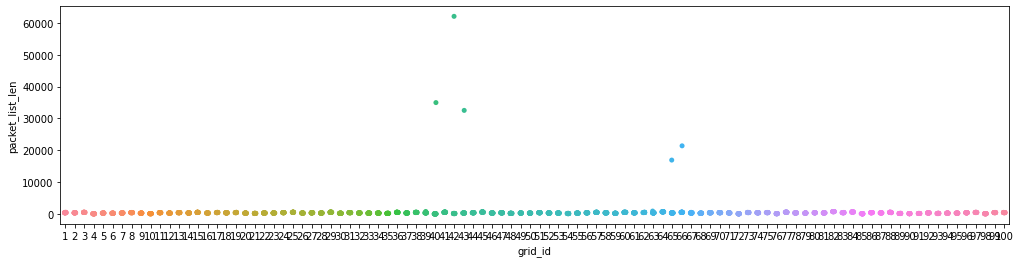

In [12]:
plt.figure(figsize=(17, 4))
strip = sns.stripplot(x=traces["grid_id"], y=traces["packet_list_len"])
plt.show()


In order to identify where do the observed outliers come from, we compute the Z-Score of the column. Basically, center and normalize our column's values and will identify the values that differ from the mean of more than 3 standard-deviations ($z>3$) which is a standard measure to detect huge outliers.

,name,index,grid_id,packet_list_len
362,trace_01_04_14h_grid_65.pcap,10414,65,16952
363,trace_01_04_14h_grid_66.pcap,10414,66,21424
1335,trace_18_04_15h_grid_40.pcap,180415,40,34992
1337,trace_18_04_15h_grid_42.pcap,180415,42,62056
1338,trace_18_04_15h_grid_43.pcap,180415,43,32545


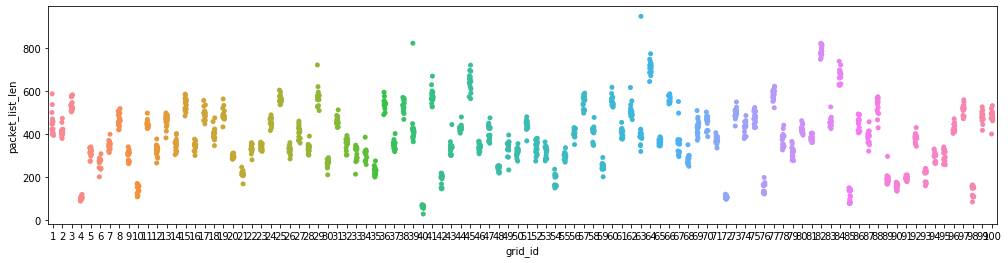

In [13]:
z = np.abs(stats.zscore(traces["packet_list_len"]))
outliers = traces[z > 3]
display(outliers)
filtered = traces[z < 3]
plt.figure(figsize=(17, 4))
strip = sns.stripplot(x=filtered["grid_id"], y=filtered["packet_list_len"])
plt.show()


These outliers come from the same capture and are issued by 2 successive queries. We suppose those are not meaningful and probably shows a connection issue from the capture. To have a fair training set and not reduce the signal generated by some grid traces, we decide to discard this trace and can make other captures to have consistent results.

In [14]:
selected_traces = traces[~traces["index"].isin(outliers["index"])]


### Data extraction
Now we are pretty confident we kept useful data only, we can therefore go ahead and extract the packets as defined by `Packet` type.

In [15]:
def get_first_packet_timestamp(trace_name: str, root: str = "traces") -> float:
    """Extracts the timestamp from the first packet of a trace"""
    timestamp = None
    with PcapReader("{}/{}".format(root, trace_name)) as pcap:
        timestamp = pcap.read_packet().time
    return float(timestamp)


In [16]:
def from_pcap_pkt_to_packet(pcap_pkt: scapy.packet.Packet, start: float) -> Packet:
    """Extract the desired informations from a scapy packet to return the desired tuple to represent a packet"""
    # as explained in the Packet type, timestamps are relative to the begining of the trace
    in_out, rel_timestamp = None, None
    if pcap_pkt.haslayer(IP):
        # we use a trick here: if the ip source is private, the packet is **coming from the client** (as the observer is between client and tor entry node). Every client is initialized with a private IP address as running on our laptops
        in_out = 1 if ipaddress.ip_address(pcap_pkt.getlayer(IP).src).is_private else -1
    else:
        raise ValueError("Packet without ip field")
    # due to floating point comparaison, we take care of the first packet timestamp value
    rel_timestamp = (
        0.0
        if float(pcap_pkt.time) - start < 10 ** (-7)
        else float(pcap_pkt.time) - start
    )
    return in_out, rel_timestamp


In [17]:
def from_trace_to_packets(trace_name: str, root: str = "traces") -> List[Packet]:
    """Gives the list of Packet type objects contained in the trace"""
    start = get_first_packet_timestamp(trace_name, root)
    pkt_list = []
    with PcapReader("{}/{}".format(root, trace_name)) as pcap:
        for pkt in pcap:
            pkt_list.append(from_pcap_pkt_to_packet(pkt, start))
    return pkt_list


packets = from_trace_to_packets("trace_01_04_08h_grid_4.pcap")
packets[:7]


[(1, 0.0),
 (-1, 0.7764999866485596),
 (1, 0.7771620750427246),
 (-1, 1.514267921447754),
 (1, 1.5217621326446533),
 (-1, 2.3333380222320557),
 (1, 2.335149049758911)]

In [18]:
def from_packet_list_to_rounds(
    packets: List[Packet], max_nb_rounds: int = 0
) -> Tuple[int, List[int]]:
    round_sizes = []
    current_direction = packets[0][0]
    current_size = 0
    for pkt in packets:
        if pkt[0] != current_direction:
            # appends +1*round size if outgoing round or -1*round size if incomming round
            round_sizes.append(current_direction * current_size)
            current_size = 0
        current_size += 1
        current_direction = pkt[0]
    return len(round_sizes), round_sizes + [0] * (max_nb_rounds - len(round_sizes))


ex_nb_rounds, ex_rounds = from_packet_list_to_rounds(
    from_trace_to_packets("trace_01_04_08h_grid_4.pcap")
)
ex_nb_rounds, ex_rounds[:20]


(29, [1, -1, 1, -1, 1, -1, 1, -18, 1, -5, 1, -1, 1, -10, 1, -1, 1, -5, 1, -1])

Before going further, we want to have a way to know the upperbound of the number of rounds we may observe. This one 

In [19]:
def from_trace_to_nb_rounds(trace_name: str, root: str = "traces") -> int:
    packets = from_trace_to_packets(trace_name, root)
    nb_rounds, _ = from_packet_list_to_rounds(packets)
    return nb_rounds


def get_max_nb_rounds(traces: DataFrame, root: str = "traces") -> int:
    with Pool() as p:
        return max(p.map(from_trace_to_nb_rounds, list(traces["name"].unique())))


MAX_NB_ROUNDS = get_max_nb_rounds(selected_traces)


In [20]:
def from_trace_to_feature(
    trace_name: str, max_rounds: int, root: str = "traces"
) -> Features:
    trace_infos = from_file_to_trace_tuple(trace_name, root)
    packets = from_trace_to_packets(trace_name, root)
    feature = dict()
    feature["label"] = [trace_infos[2]]
    feature["size"] = [len(packets)]
    feature["time"] = [packets[-1][1]]
    nb_rounds, rounds = from_packet_list_to_rounds(packets, max_rounds)
    feature["nb_rounds"] = [nb_rounds]
    for i, round in enumerate(rounds):
        feature["round{}".format(i + 1)] = [round]
    return feature


list(from_trace_to_feature("trace_01_04_08h_grid_4.pcap", MAX_NB_ROUNDS).items())[:10]


[('label', [4]),
 ('size', [104]),
 ('time', [11.860253095626831]),
 ('nb_rounds', [29]),
 ('round1', [1]),
 ('round2', [-1]),
 ('round3', [1]),
 ('round4', [-1]),
 ('round5', [1]),
 ('round6', [-1])]

In [21]:
def get_features_for_traces(
    index: int,
    traces: DataFrame = selected_traces,
    max_rounds: int = MAX_NB_ROUNDS,
    root: str = "traces",
) -> DataFrame:
    all_features = dict()
    for trace_name in traces[traces["index"] == index]["name"]:
        features = from_trace_to_feature(trace_name, max_rounds, root)
        for ft in features.keys():
            if not ft in all_features:
                all_features[ft] = []
            all_features[ft] += features[ft]
    return pd.DataFrame(all_features)


features_df = get_features_for_traces(10408, selected_traces, MAX_NB_ROUNDS)
features_df.info()
display(features_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 234 entries, label to round230
dtypes: float64(1), int64(233)
memory usage: 182.9 KB


,label,size,time,nb_rounds,round1,round2,round3,round4,round5,round6,...,round221,round222,round223,round224,round225,round226,round227,round228,round229,round230
0,1,461,30.517804,87,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
1,10,137,10.819218,29,1,-1,1,-1,2,-1,...,0,0,0,0,0,0,0,0,0,0
2,100,479,7.959373,98,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
3,11,499,27.349815,103,1,-1,1,-1,2,-2,...,0,0,0,0,0,0,0,0,0,0
4,12,379,19.287706,77,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,274,6.978704,51,1,-1,1,-2,1,-1,...,0,0,0,0,0,0,0,0,0,0
96,96,456,8.962877,95,1,-1,2,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
97,97,517,11.059344,104,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
98,98,113,3.782149,30,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
def create_full_dataframe() -> DataFrame:
    with Pool() as p:
        data_frames = p.map(
            get_features_for_traces, list(selected_traces["index"].unique())
        )
        return reduce(lambda x, y: pd.concat([x, y]), data_frames)


full_df = create_full_dataframe()
full_df.info()
display(full_df)
full_df.to_csv("features.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 41
Columns: 234 entries, label to round230
dtypes: float64(1), int64(233)
memory usage: 2.7 MB


,label,size,time,nb_rounds,round1,round2,round3,round4,round5,round6,...,round221,round222,round223,round224,round225,round226,round227,round228,round229,round230
0,1,461,30.517804,87,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
1,10,137,10.819218,29,1,-1,1,-1,2,-1,...,0,0,0,0,0,0,0,0,0,0
2,100,479,7.959373,98,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
3,11,499,27.349815,103,1,-1,1,-1,2,-2,...,0,0,0,0,0,0,0,0,0,0
4,12,379,19.287706,77,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,95,274,5.899930,56,1,-1,1,-1,1,-1,...,0,0,0,0,0,0,0,0,0,0
38,96,417,9.778009,84,1,-1,1,-1,2,-2,...,0,0,0,0,0,0,0,0,0,0
39,97,488,10.820661,98,1,-1,1,-2,2,-2,...,0,0,0,0,0,0,0,0,0,0
40,98,112,3.562152,26,1,-1,1,-3,1,-1,...,0,0,0,0,0,0,0,0,0,0


In [23]:
pd.read_csv("features.csv").values[1222][:12]


array([ 29.        , 571.        ,  15.12548304, 114.        ,
         1.        ,  -1.        ,   1.        ,  -1.        ,
         1.        ,  -1.        ,   1.        , -14.        ])